# Example 1 – Optics of internally vs externally mixed lognormal aerosols with homogeneous, core-shell, and fractal morphologies

This example compares the bulk optical properties of two idealized aerosol populations:
an internally mixed population (all particles share the same composition) and an
externally mixed population (black carbon and sulfate exist in separate particles). We will also examine the effects of particle morphology on the optical properties of both populations.

Both populations are built from simple lognormal size distributions, then passed to
`part2pop` to compute bulk optical properties and visualize how they respond to
relative humidity, mixing state, and morphology.

### What you’ll learn

- How to use `build_population` with the `"binned_lognormals"` configuration.
- How to represent **internal** vs **external** mixtures in the population config.
- How to compute and plot bulk optical quantities (e.g. absorption, extinction) for
  different relative humidities and morphologies.


## Step 1 – Define lognormal size distribution and mixing state

We start by defining a simple lognormal size distribution representing a generic aerosol
population (total number, geometric mean diameter, and geometric standard deviation).

We then create two *population configurations* that use this same size distribution but
different mixing states:

- **Internally mixed** – each particle contains both black carbon and sulfate.
- **Externally mixed** – some particles are pure black carbon, others are pure sulfate.

In [5]:
from part2pop.population import build_population
import numpy as np 

# lognormal size distribution parameters
Ntot = 1e9
GMD = 100e-9
GSD = 1.6
frac_BC = 0.2
N_bins = 50 
D_min = 1e-9
D_max = 1e-4

# Internally mixed: each particle has both BC and sulfate
pop_cfg_internallyMixed = {
    "type": "binned_lognormals",
    "N": [Ntot],
    "GMD": [GMD],
    "GSD": [GSD],
    "aero_spec_names": [["SO4","BC"]], # one population of internally mixed particles
    "aero_spec_fracs": [[(1.-frac_BC), frac_BC]], # mass fraction of each species in each particle
    "N_bins": N_bins,
    "N_sigmas": 5, # D_range is +/- 5 geometric standard deviations
  }

# Externally mixed: separate BC and sulfate particle populations
pop_cfg_externallyMixed = {
    "type": "binned_lognormals",
    "N": [Ntot*(1-frac_BC), Ntot*frac_BC], # sulfate and BC split into separate populations
    "GMD": [GMD, GMD],
    "GSD": [GSD, GSD],
    "aero_spec_names": [["SO4"], ["BC"]], #one population of pure sulfate, one of pure BC
    "aero_spec_fracs": [[1.0], [1.0]], # pure(ish) species
    "N_bins": N_bins,
    "N_sigmas": 5, # D_range is +/- 5 geometric standard deviations
  }



## Step 2 – Build `part2pop` populations

Next, we pass the configuration dictionaries into `build_population`. This constructs `Population` objects that hold the binned size distribution and composition information.

In [6]:
pop_configs = [pop_cfg_internallyMixed, pop_cfg_externallyMixed]
pop_int = build_population(pop_cfg_internallyMixed)
pop_ext = build_population(pop_cfg_externallyMixed)

## Step 3 – Plot optical properties for different morphologies and interpret the results

We then ask `part2pop` to compute bulk optical properties such as:

- Extinction coefficient
- Scattering coefficient
- Absorption coefficient

as a function of wavelength for three particle morphologies.

In this example we focus on `b_abs`, the bulk absorption coefficient, to highlight how particle mixing statre and morphology influences light absorption at **dry conditions**. Each particle morphology uses the following package to calculate light absorption:

- "homogeneous" --> PyMieScatt (MieQ)
- "core-shell" --> PyMieScatt (MieQCoreShell)
- "fractal" --> pyBCabs

Finally, we use the built-in visualization helpers to plot the optical property of
interest for each morphology. 

Things to look for:

- How does absorption change between morphologies?
- How do the impacts of morphology on light absorption change across wavelengths?

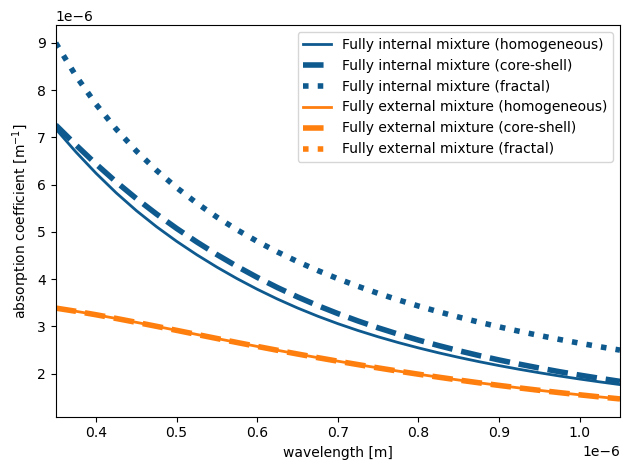

In [ ]:
from part2pop.viz.style import StyleManager, Theme
from part2pop.viz.builder import build_plotter
mgr = StyleManager(Theme(), deterministic=False)

series = [
    {"key": "int", "population": pop_int, "label": "Fully internal mixture"},
    {"key": "ext", "population": pop_ext, "label": "Fully external mixture"},
]
line_styles = mgr.plan("line", [s["key"] for s in series])

import matplotlib.pyplot as plt
from helpers.pymiescatt_comparison import pymiescatt_lognormal_optics

varname = "b_abs"
fig, ax = plt.subplots()
for s in series:
    cfg = {
        "varname": varname,
        "var_cfg": {"morphology":"homogeneous", "wvl_grid": np.linspace(350e-9,1050e-9,29), "rh_grid": [0.]},  # simple case: single x
        "style": line_styles[s["key"]],
    }
    plotter = build_plotter("state_line", cfg)
    plotter.plot(s["population"], ax, label=s["label"]+" (homogeneous)")
    
    cfg_cs = cfg.copy()
    cfg_cs["var_cfg"]["morphology"] = "core-shell"
    cfg_cs["style"] = line_styles[s["key"]].copy()
    cfg_cs["style"]["linestyle"] = "--"
    cfg_cs["style"]["linewidth"] = 2*cfg["style"]["linewidth"]
    plotter_cs = build_plotter("state_line", cfg_cs)
    plotter_cs.plot(s["population"], ax, label=s["label"]+" (core-shell)")
    
    cfg_frac = cfg.copy()
    cfg_frac["var_cfg"]["morphology"] = "fractal"
    cfg_frac["style"] = line_styles[s["key"]].copy()
    cfg_frac["style"]["linestyle"] = "dotted"
    cfg_frac["style"]["linewidth"] = 2*cfg["style"]["linewidth"]
    plotter_frac = build_plotter("state_line", cfg_frac)
    plotter_frac.plot(s["population"], ax, label=s["label"]+" (fractal)")

ax.legend(); fig.tight_layout()


## Step 4 – Plot optical properties different humidities assuming a single morphology and interpret the results

We can also ask `part2pop` to compute bulk optical properties at different relative humidities. In this example we focus on `b_abs`, the bulk absorption coefficient, to highlight how mixing state and RH influence light absorption.

We use the built-in visualization helpers to plot the optical property of interest for each population, assuming a core-shell morphology. Solid lines show values at **dry conditions**, while dashed lines show the same quantity at **RH = 95%**.

Things to look for:

- How does absorption change between internal and external mixtures?
- How does high RH (95%) modify the optical properties relative to dry conditions?

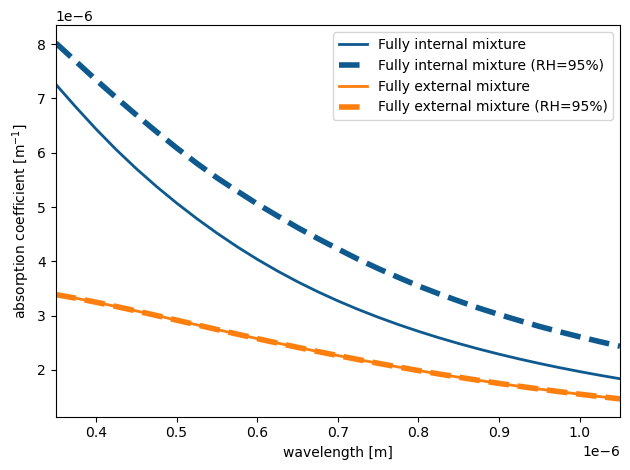

In [8]:
from part2pop.viz.style import StyleManager, Theme
from part2pop.viz.builder import build_plotter
mgr = StyleManager(Theme(), deterministic=False)

series = [
    {"key": "int", "population": pop_int, "label": "Fully internal mixture"},
    {"key": "ext", "population": pop_ext, "label": "Fully external mixture"},
]
line_styles = mgr.plan("line", [s["key"] for s in series])

import matplotlib.pyplot as plt
from helpers.pymiescatt_comparison import pymiescatt_lognormal_optics

varname = "b_abs"
fig, ax = plt.subplots()
for s in series:
    cfg = {
        "varname": varname,
        "var_cfg": {"morphology":"core-shell", "wvl_grid": np.linspace(350e-9,1050e-9,29), "rh_grid": [0.]},  # simple case: single x
        "style": line_styles[s["key"]],
    }
    plotter = build_plotter("state_line", cfg)
    plotter.plot(s["population"], ax, label=s["label"])
    
    cfg_rh = cfg.copy()
    cfg_rh["var_cfg"]["rh_grid"] = [0.95]
    cfg_rh["style"] = line_styles[s["key"]].copy()
    cfg_rh["style"]["linestyle"] = "--"
    cfg_rh["style"]["linewidth"] = 2*cfg["style"]["linewidth"]
    plotter_rh50 = build_plotter("state_line", cfg_rh)
    plotter_rh50.plot(s["population"], ax, label=s["label"]+" (RH=95%)")

ax.legend(); fig.tight_layout()